# Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit,njit,float64,int32
import numba as nb
import pandas as pd
import scipy.stats
import math


# Parameters

In [4]:
tiempo_vida_maximo = 150            #Para que los resultados obtenidos se encuentren ligados a realidad biologica
alpha_damage_propagation = 0.062    #Tasa de propagacion de daño
coupling_factor = 0.089             #Factor de acoplamiento entre frailty index y gompertz
mortality_rate = 4.3*(10**(-4))     #Tasa de mortalidad

# Gillespie

In [5]:
@njit()
def Gillespie(trp0,tmax, N_total, disease_rate):
    """
    Esta funcion se emplea solamente para hacer la evolución de un paso individual en la celula. Evoluciona no un paso temporal, 
    pero si temporalmente la cantidad de veces que pueda evolucionar antes del tmax en una corrida
    """
    t,N, died =trp0 

    while t < tmax and not died :
        s_1 =  ((N_total-N)/(N_total))*(alpha_damage_propagation*N + disease_rate*N_total)
        s_2 = mortality_rate*((N/N_total)**(coupling_factor/alpha_damage_propagation))
        S_T = s_1 + s_2 

        τ = (-1/S_T)*np.log(np.random.rand())
        x = np.random.rand()

        if x <= (s_1)/S_T:
            N += 1
        else: 
            died = True
            break
        t+=τ
    return np.array([t,N, died]) 
@njit()
def Estado_celula(X0,tiempos, N_total, disease_rate):
    
    X = np.empty((len(tiempos),len(X0)))
    X[:] = np.nan
    X[0] = X0
    
    for i in range(1,len(tiempos)):
        X[i] = Gillespie(X[i-1],tiempos[i], N_total, disease_rate)
        if X[i][2]:
            break
    return X

# Experiments

In [741]:
N_total_steps = [7,15,30,45,60,75,90, 120, 150, 200, 300]
#disease_rate_steps = [0.0025, 0.005, 0.01, 0.02, 0.04]
disease_rate_steps = [0.00045]
simulaciones = np.empty((len(N_total_steps),len(disease_rate_steps)), dtype=object)

In [742]:
for idx_D, D in enumerate(tqdm(disease_rate_steps)):
    for idx_N, N in enumerate(tqdm(N_total_steps)):
        x0 = np.array([0., 0., False])
        num_cel = 1*(10**5) #Cantidad de personas que se estan simulando
        celulas = np.array([Estado_celula(x0,np.arange(0.,tiempo_vida_maximo,1.), N,D ) for i in range(num_cel)])
        simulaciones[idx_N][idx_D] = celulas

100%|██████████| 1/1 [00:59<00:00, 59.74s/it]


# Phenomenological Data

In [8]:
import csv
phenomenological_age = []
phenomenological_frailty_index = []
with open("Phenomenological_data.csv", 'r') as file:
  csvreader = csv.reader(file, delimiter=",")
  for fila in csvreader:
    phenomenological_age.append(float(fila[0]))
    phenomenological_frailty_index.append(float(fila[1]))

In [9]:
import csv
frailty_index_data_age = []
frailty_index_data_index = []
with open("frailty_index_data_GNM.csv", 'r') as file:
  csvreader = csv.reader(file, delimiter=",")
  for fila in csvreader:
    frailty_index_data_age.append(float(fila[0]))
    frailty_index_data_index.append(float(fila[1]))

In [13]:
N_total_steps = [1000]
disease_rate_steps = [0.00025, 0.00025*2, 0.00025*4, 0.00025*8]
simulaciones = np.empty((len(N_total_steps),len(disease_rate_steps)), dtype=object)

for idx_D, D in enumerate(tqdm(disease_rate_steps)):
    for idx_N, N in enumerate(tqdm(N_total_steps)):
        x0 = np.array([0., 10., False])
        num_cel = 1*(10**5) #Cantidad de personas que se estan simulando
        celulas = np.array([Estado_celula(x0,np.arange(0.,tiempo_vida_maximo,1.), N,D ) for i in range(num_cel)])
        simulaciones[idx_N][idx_D] = celulas

100%|██████████| 4/4 [01:07<00:00, 16.93s/it]


In [14]:
curva_promedio_stochastic_model_1 = np.zeros((len(simulaciones[0][0][0])))
curva_promedio_stochastic_model_2 = np.zeros((len(simulaciones[0][1][0])))
curva_promedio_stochastic_model_3 = np.zeros((len(simulaciones[0][2][0])))
curva_promedio_stochastic_model_4 = np.zeros((len(simulaciones[0][3][0])))

for i in tqdm(np.arange((len(simulaciones[0][0][0])))):
    promedio1 = np.nanmean(simulaciones[0][0][:,i,1])/N_total_steps[0]
    promedio2 = np.nanmean(simulaciones[0][1][:,i,1])/N_total_steps[0]
    promedio3 = np.nanmean(simulaciones[0][2][:,i,1])/N_total_steps[0]
    promedio4 = np.nanmean(simulaciones[0][3][:,i,1])/N_total_steps[0]

    curva_promedio_stochastic_model_1[i] = promedio1
    curva_promedio_stochastic_model_2[i] = promedio2
    curva_promedio_stochastic_model_3[i] = promedio3
    curva_promedio_stochastic_model_4[i] = promedio4

100%|██████████| 150/150 [00:01<00:00, 78.85it/s] 


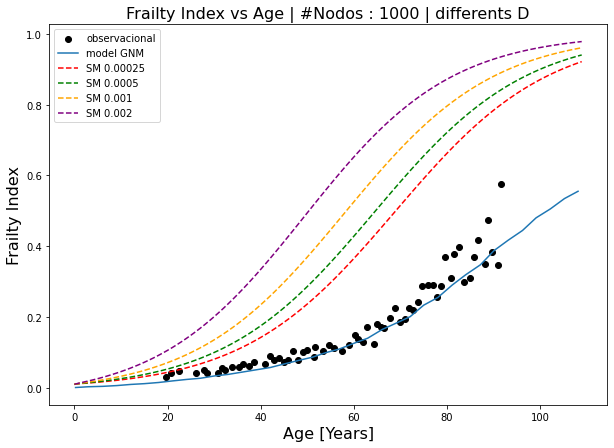

In [15]:
plt.figure(figsize = (10,7))
plt.title(rf"Frailty Index vs Age | #Nodos : {N_total_steps[0]} | differents D" , fontsize =16)
plt.scatter(phenomenological_age, phenomenological_frailty_index, color = "black", label = "observacional")
plt.plot(frailty_index_data_age, frailty_index_data_index, label = "model GNM")
plt.plot(curva_promedio_stochastic_model_1[0:110], label = f"SM {disease_rate_steps[0]}", linestyle = "--", color = "red")
plt.plot(curva_promedio_stochastic_model_2[0:110], label = f"SM {disease_rate_steps[1]}", linestyle = "--", color = "green")
plt.plot(curva_promedio_stochastic_model_3[0:110], label = f"SM {disease_rate_steps[2]}", linestyle = "--", color = "orange")
plt.plot(curva_promedio_stochastic_model_4[0:110], label = f"SM {disease_rate_steps[3]}", linestyle = "--", color = "purple")

plt.xlabel(r"Age [Years]", fontsize =16)
plt.ylabel(r"Frailty Index", fontsize =16)
plt.legend()
#plt.savefig("Frailty_index_comportamiento_diferente_D.jpg", dpi = 500)

In [18]:
N_total_steps = [600]
disease_rate_steps = [0.00025, 0.00025*2, 0.00025*4, 0.00025*8]
simulaciones = np.empty((len(N_total_steps),len(disease_rate_steps)), dtype=object)

for idx_D, D in enumerate(tqdm(disease_rate_steps)):
    for idx_N, N in enumerate(tqdm(N_total_steps)):
        x0 = np.array([0., 0., False])
        num_cel = 1*(10**5) #Cantidad de personas que se estan simulando
        celulas = np.array([Estado_celula(x0,np.arange(0.,tiempo_vida_maximo,1.), N,D ) for i in range(num_cel)])
        simulaciones[idx_N][idx_D] = celulas

100%|██████████| 4/4 [00:48<00:00, 12.18s/it]


In [19]:
curva_promedio_stochastic_model_1 = np.zeros((len(simulaciones[0][0][0])))
curva_promedio_stochastic_model_2 = np.zeros((len(simulaciones[0][1][0])))
curva_promedio_stochastic_model_3 = np.zeros((len(simulaciones[0][2][0])))
curva_promedio_stochastic_model_4 = np.zeros((len(simulaciones[0][3][0])))

for i in tqdm(np.arange((len(simulaciones[0][0][0])))):
    promedio1 = np.nanmean(simulaciones[0][0][:,i,1])/N_total_steps[0]
    promedio2 = np.nanmean(simulaciones[0][1][:,i,1])/N_total_steps[0]
    promedio3 = np.nanmean(simulaciones[0][2][:,i,1])/N_total_steps[0]
    promedio4 = np.nanmean(simulaciones[0][3][:,i,1])/N_total_steps[0]

    curva_promedio_stochastic_model_1[i] = promedio1
    curva_promedio_stochastic_model_2[i] = promedio2
    curva_promedio_stochastic_model_3[i] = promedio3
    curva_promedio_stochastic_model_4[i] = promedio4

100%|██████████| 150/150 [00:02<00:00, 73.49it/s] 


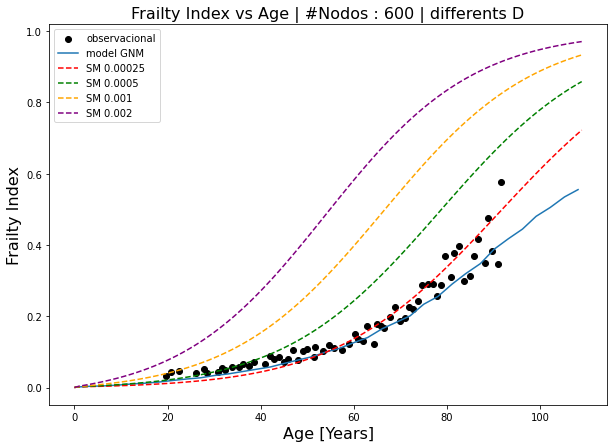

In [20]:
plt.figure(figsize = (10,7))
plt.title(rf"Frailty Index vs Age | #Nodos : {N_total_steps[0]} | differents D" , fontsize =16)
plt.scatter(phenomenological_age, phenomenological_frailty_index, color = "black", label = "observacional")
plt.plot(frailty_index_data_age, frailty_index_data_index, label = "model GNM")
plt.plot(curva_promedio_stochastic_model_1[0:110], label = f"SM {disease_rate_steps[0]}", linestyle = "--", color = "red")
plt.plot(curva_promedio_stochastic_model_2[0:110], label = f"SM {disease_rate_steps[1]}", linestyle = "--", color = "green")
plt.plot(curva_promedio_stochastic_model_3[0:110], label = f"SM {disease_rate_steps[2]}", linestyle = "--", color = "orange")
plt.plot(curva_promedio_stochastic_model_4[0:110], label = f"SM {disease_rate_steps[3]}", linestyle = "--", color = "purple")

plt.xlabel(r"Age [Years]", fontsize =16)
plt.ylabel(r"Frailty Index", fontsize =16)
plt.legend()
plt.savefig("Frailty_index_comportamiento_diferente_D_600.jpg", dpi = 500)

100%|██████████| 150/150 [00:00<00:00, 315.90it/s]


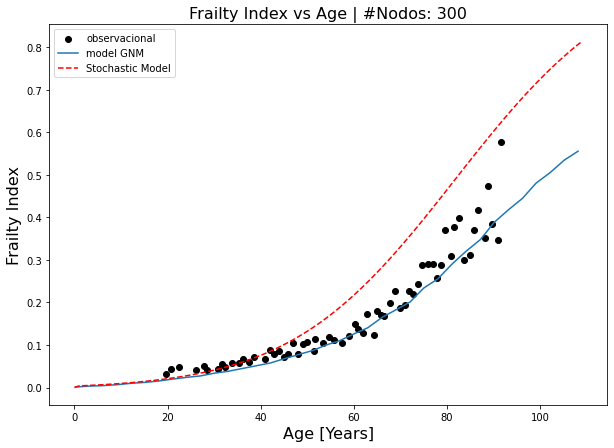

In [938]:
numero = 10
curva_promedio_stochastic_model_300 = np.zeros((len(simulaciones[numero][0][0])))
for i in tqdm(np.arange((len(simulaciones[numero][0][0])))):
    promedio = np.nanmean(simulaciones[numero][0][:,i,1])/N_total_steps[numero]
    curva_promedio_stochastic_model_300[i] = promedio

plt.figure(figsize = (10,7))
plt.title(rf"Frailty Index vs Age | #Nodos: {N_total_steps[numero]}", fontsize =16)
plt.scatter(phenomenological_age, phenomenological_frailty_index, color = "black", label = "observacional")
plt.plot(frailty_index_data_age, frailty_index_data_index, label = "model GNM")
plt.plot(curva_promedio_stochastic_model_300[0:110], label = "Stochastic Model", linestyle = "--", color = "red")
plt.xlabel(r"Age [Years]", fontsize =16)
plt.ylabel(r"Frailty Index", fontsize =16)
plt.legend()
plt.savefig(f"frailty_index_nodos_{N_total_steps[numero]}.jpg", dpi = 200)

In [ ]:
promedio_1 = np.nanmean(simulaciones[0][0][:,i,1])/7

# Distribuciones P(f)

In [868]:
import matplotlib.pyplot as plt
import numpy as np

bins_histograma_65_69 = [21,21,30,22,29,25,30,30,31,30,29]
bins_histograma_80_85 = [21,21,30,22,29,25,30,30,35,27,30]
bins_histograma_90_95 = [21,21,30,22,29,25,30,30,25,33,22]
bins_histograma_100_105 = [21,21,30,22,29,25,30,30,30,28,32]

datos_65_69 = np.empty((len(N_total_steps)), dtype=object)
hist_65_69 = np.empty((len(N_total_steps)), dtype=object)
max_points_65_69 = np.empty((len(N_total_steps)), dtype=object)

datos_80_85 = np.empty((len(N_total_steps)), dtype=object)
hist_80_85 = np.empty((len(N_total_steps)), dtype=object)
max_points_80_85 = np.empty((len(N_total_steps)), dtype=object)

datos_90_95 = np.empty((len(N_total_steps)), dtype=object)
hist_90_95 = np.empty((len(N_total_steps)), dtype=object)
max_points_90_95 = np.empty((len(N_total_steps)), dtype=object)

datos_100_105 = np.empty((len(N_total_steps)), dtype=object)
hist_100_105 = np.empty((len(N_total_steps)), dtype=object)
max_points_100_105 = np.empty((len(N_total_steps)), dtype=object)

for i in range(0, len(N_total_steps)):
    dato_65_69 = np.concatenate((simulaciones[i][0][:,55:59,1]))
    dato_65_69 = dato_65_69[~np.isnan(dato_65_69)]

    datos_65_69[i] = dato_65_69
    hist, bin = np.histogram(datos_65_69[i], density=True, bins = bins_histograma_65_69[i] )


    max_point = bin[:-1] + np.diff(bin)/2
    max_points_filtered_a = max_point[hist > 0]

    hist = hist[hist > 0]

    hist_65_69[i] = hist*100
    max_points_65_69[i] = max_points_filtered_a/N_total_steps[i]


####
    dato_80_85 = np.concatenate((simulaciones[i][0][:,70:75,1]))
    dato_80_85 = dato_80_85[~np.isnan(dato_80_85)]

    datos_80_85[i] = dato_80_85
    hist, bin = np.histogram(datos_80_85[i], density=True, bins = bins_histograma_80_85[i] )


    max_point = bin[:-1] + np.diff(bin)/2
    max_points_filtered_a = max_point[hist > 0]

    hist = hist[hist > 0]

    hist_80_85[i] = hist*100
    max_points_80_85[i] = max_points_filtered_a/N_total_steps[i]

###
    dato_90_95 = np.concatenate((simulaciones[i][0][:,80:85,1]))
    dato_90_95 = dato_90_95[~np.isnan(dato_90_95)]

    datos_90_95[i] = dato_90_95
    hist, bin = np.histogram(datos_90_95[i], density=True, bins = bins_histograma_90_95[i] )


    max_point = bin[:-1] + np.diff(bin)/2
    max_points_filtered_a = max_point[hist > 0]

    hist = hist[hist > 0]

    hist_90_95[i] = hist*100
    max_points_90_95[i] = max_points_filtered_a/N_total_steps[i]

####

    dato_100_105 = np.concatenate((simulaciones[i][0][:,90:95,1]))
    dato_100_105 = dato_100_105[~np.isnan(dato_100_105)]

    datos_100_105[i] = dato_100_105
    hist, bin = np.histogram(datos_100_105[i], density=True, bins = bins_histograma_100_105[i] )


    max_point = bin[:-1] + np.diff(bin)/2
    max_points_filtered_a = max_point[hist > 0]

    hist = hist[hist > 0]

    hist_100_105[i] = hist*100
    max_points_100_105[i] = max_points_filtered_a/N_total_steps[i]

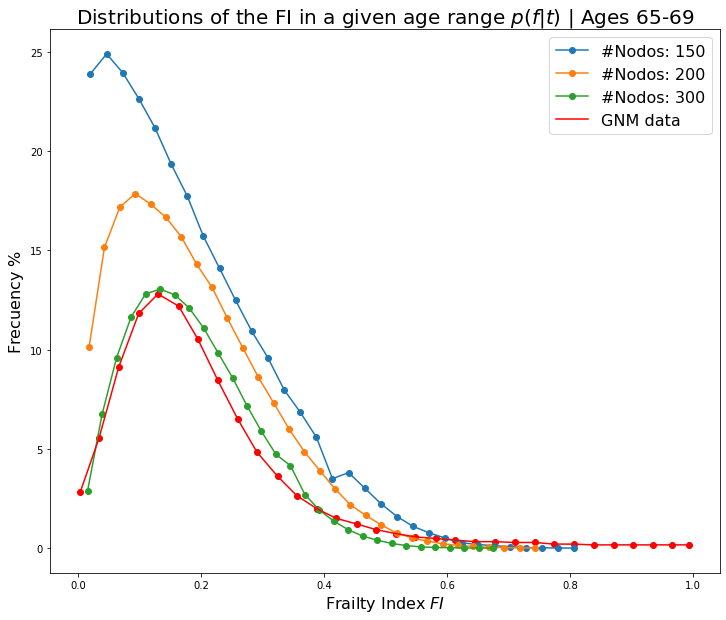

In [851]:
plt.figure(figsize=(12,10))
plt.title(r"Distributions of the FI in a given age range $p(f|t)$ | Ages 65-69", fontsize = 20)
for i in range(8, len(N_total_steps)):

    plt.plot(max_points_65_69[i], hist_65_69[i]*10, marker='o', label = f"#Nodos: {N_total_steps[i]}")

plt.scatter(frailty_index_GNM_data_65_69, frecuency_GNM_data_65_69, color = "red")
plt.plot(frailty_index_GNM_data_65_69, frecuency_GNM_data_65_69, label = "GNM data", color = "red")

plt.xlabel(r'Frailty Index $FI$', fontsize = 16)
plt.ylabel(r'Frecuency $\%$', fontsize = 16)
plt.legend(fontsize = 16)
plt.savefig("Comparacion_GNM_stochastic_65_69.jpg", dpi = 500)
plt.show()

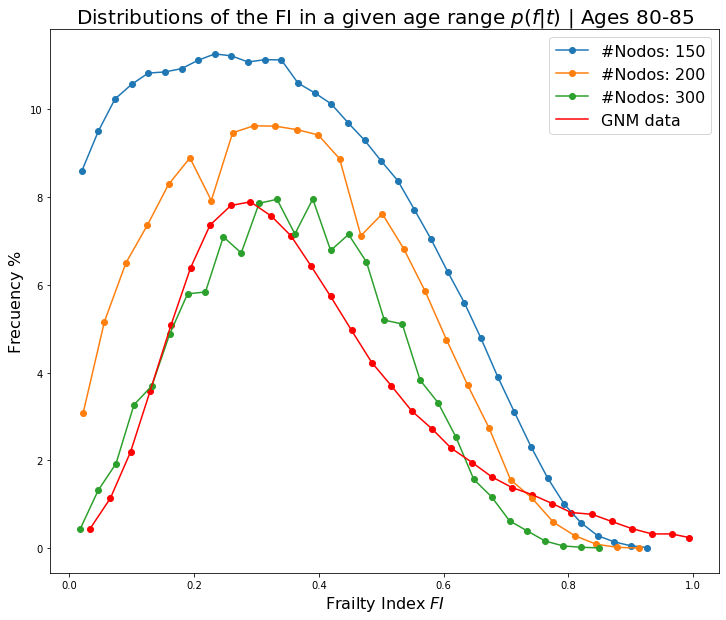

In [859]:
plt.figure(figsize=(12,10))
plt.title(r"Distributions of the FI in a given age range $p(f|t)$ | Ages 80-85", fontsize = 20)
for i in range(8, len(N_total_steps)):

    plt.plot(max_points_80_85[i], hist_80_85[i]*10, marker='o', label = f"#Nodos: {N_total_steps[i]}")

plt.scatter(frailty_index_GNM_data_80_85, frecuency_GNM_data_80_85, color = "red")
plt.plot(frailty_index_GNM_data_80_85, frecuency_GNM_data_80_85, label = "GNM data", color = "red")

plt.xlabel(r'Frailty Index $FI$', fontsize = 16)
plt.ylabel(r'Frecuency $\%$', fontsize = 16)
plt.legend(fontsize = 16)
plt.savefig("Comparacion_GNM_stochastic_80_85.jpg", dpi = 500)
plt.show()

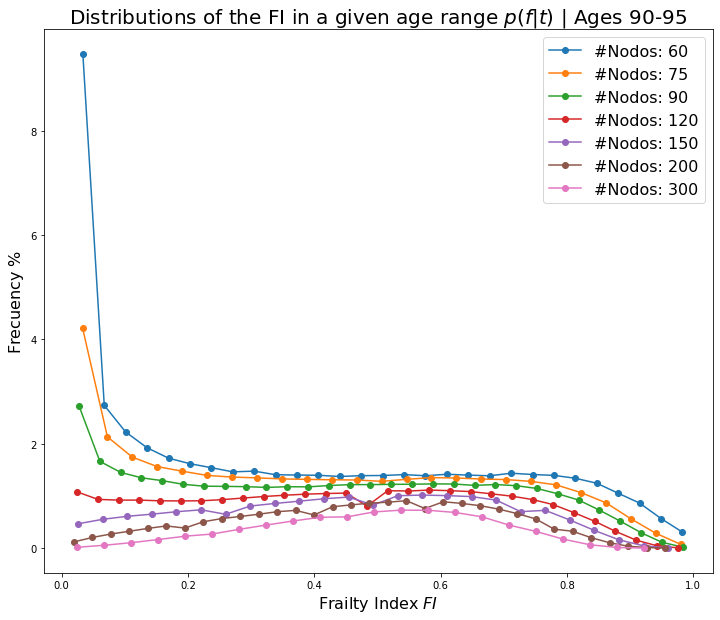

In [878]:
plt.figure(figsize=(12,10))
plt.title(r"Distributions of the FI in a given age range $p(f|t)$ | Ages 90-95", fontsize = 20)
for i in range(4, len(N_total_steps)):

    plt.plot(max_points_90_95[i], hist_90_95[i], marker='o', label = f"#Nodos: {N_total_steps[i]}")

#plt.scatter(frailty_index_GNM_data_90_95, frecuency_GNM_data_90_95, color = "red")
#plt.plot(frailty_index_GNM_data_90_95, frecuency_GNM_data_90_95, label = "GNM data", color = "red")

plt.xlabel(r'Frailty Index $FI$', fontsize = 16)
plt.ylabel(r'Frecuency $\%$', fontsize = 16)
plt.legend(fontsize = 16)
#plt.savefig("Comparacion_GNM_stochastic_90_95.jpg", dpi = 500)
plt.show()

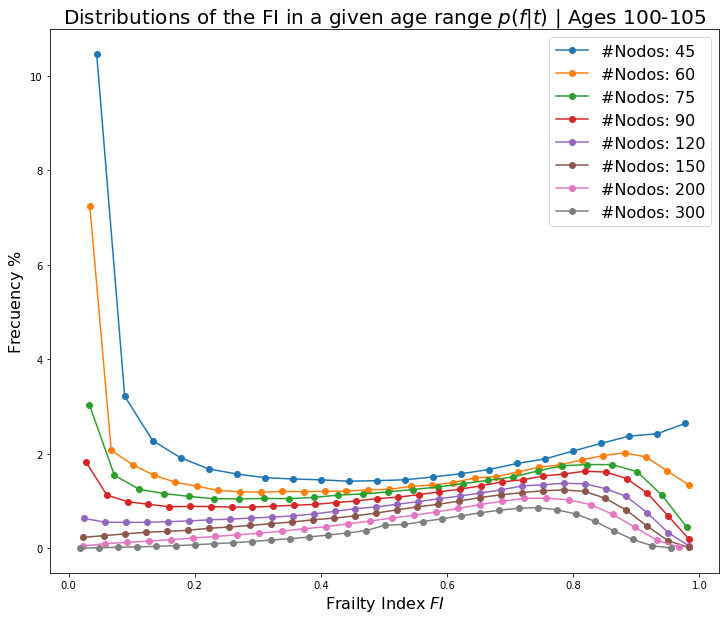

In [875]:
plt.figure(figsize=(12,10))
plt.title(r"Distributions of the FI in a given age range $p(f|t)$ | Ages 100-105", fontsize = 20)
for i in range(3, len(N_total_steps)):

    plt.plot(max_points_100_105[i], hist_100_105[i], marker='o', label = f"#Nodos: {N_total_steps[i]}")

#plt.scatter(frailty_index_GNM_data_100_105, frecuency_GNM_data_100_105, color = "red")
#plt.plot(frailty_index_GNM_data_100_105, frecuency_GNM_data_100_105, label = "GNM data", color = "red")

plt.xlabel(r'Frailty Index $FI$', fontsize = 16)
plt.ylabel(r'Frecuency $\%$', fontsize = 16)
plt.legend(fontsize = 16)
#plt.savefig("Comparacion_GNM_stochastic_100_105.jpg", dpi = 500)
plt.show()

# GNM Data

In [785]:
frailty_index_GNM_data_65_69 = []
frecuency_GNM_data_65_69 = []
with open("data_GNM_65_69.csv", 'r') as file:
  csvreader = csv.reader(file, delimiter=",")
  for fila in csvreader:
    frailty_index_GNM_data_65_69.append(float(fila[0]))
    frecuency_GNM_data_65_69.append(float(fila[1]))

frailty_index_GNM_data_80_85 = []
frecuency_GNM_data_80_85 = []
with open("data_GNM_80_85.csv", 'r') as file:
  csvreader = csv.reader(file, delimiter=",")
  for fila in csvreader:
    frailty_index_GNM_data_80_85.append(float(fila[0]))
    frecuency_GNM_data_80_85.append(float(fila[1]))

frailty_index_GNM_data_90_95 = []
frecuency_GNM_data_90_95 = []
with open("data_GNM_90_95.csv", 'r') as file:
  csvreader = csv.reader(file, delimiter=",")
  for fila in csvreader:
    frailty_index_GNM_data_90_95.append(float(fila[0]))
    frecuency_GNM_data_90_95.append(float(fila[1]))

frailty_index_GNM_data_100_105 = []
frecuency_GNM_data_100_105 = []
with open("data_GNM_100_105.csv", 'r') as file:
  csvreader = csv.reader(file, delimiter=",")
  for fila in csvreader:
    frailty_index_GNM_data_100_105.append(float(fila[0]))
    frecuency_GNM_data_100_105.append(float(fila[1]))

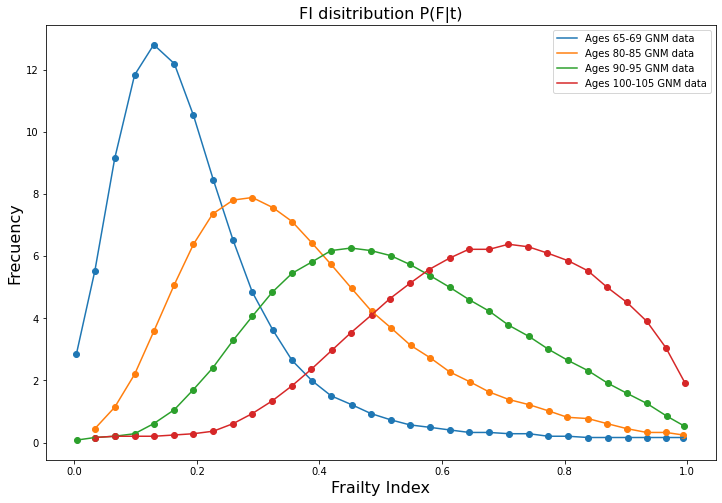

In [834]:
plt.figure(figsize=(12,8))
plt.scatter(frailty_index_GNM_data_65_69, frecuency_GNM_data_65_69)
plt.plot(frailty_index_GNM_data_65_69, frecuency_GNM_data_65_69, label = "Ages 65-69 GNM data")

plt.scatter(frailty_index_GNM_data_80_85, frecuency_GNM_data_80_85)
plt.plot(frailty_index_GNM_data_80_85, frecuency_GNM_data_80_85, label = "Ages 80-85 GNM data")

plt.scatter(frailty_index_GNM_data_90_95, frecuency_GNM_data_90_95)
plt.plot(frailty_index_GNM_data_90_95, frecuency_GNM_data_90_95, label = "Ages 90-95 GNM data")

plt.scatter(frailty_index_GNM_data_100_105, frecuency_GNM_data_100_105)
plt.plot(frailty_index_GNM_data_100_105, frecuency_GNM_data_100_105, label = "Ages 100-105 GNM data")

plt.xlabel(r"Frailty Index", fontsize = 16)
plt.ylabel(r"Frecuency", fontsize = 16)
plt.title(r"FI disitribution P(F|t)", fontsize = 16)
plt.legend()


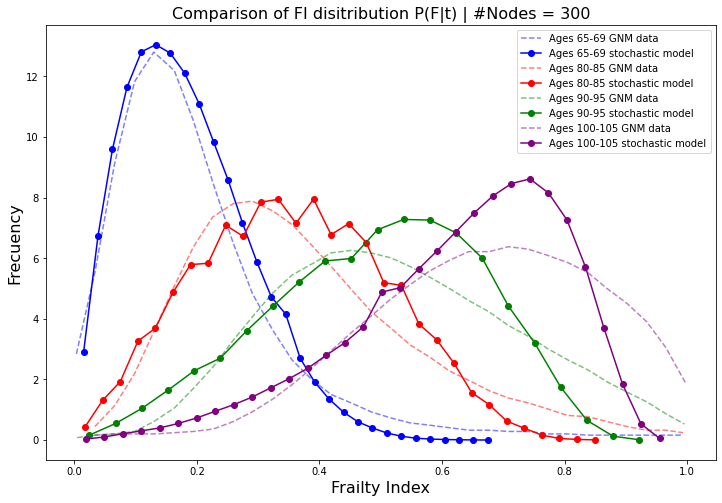

In [902]:
plt.figure(figsize=(12,8))

plt.plot(frailty_index_GNM_data_65_69, frecuency_GNM_data_65_69, label = "Ages 65-69 GNM data", color = "blue", alpha = 0.5, linestyle = "--")
plt.plot(max_points_65_69[i], hist_65_69[i]*10, marker='o', label = "Ages 65-69 stochastic model", color = "blue")

plt.plot(frailty_index_GNM_data_80_85, frecuency_GNM_data_80_85, label = "Ages 80-85 GNM data", color = "red", alpha = 0.5, linestyle = "--")
plt.plot(max_points_80_85[i], hist_80_85[i]*10, marker='o', label = "Ages 80-85 stochastic model", color = "red")

plt.plot(frailty_index_GNM_data_90_95, frecuency_GNM_data_90_95, label = "Ages 90-95 GNM data", color = "green", alpha = 0.5, linestyle = "--")
plt.plot(max_points_90_95[i], hist_90_95[i]*10, marker='o', label = "Ages 90-95 stochastic model", color = "green")

plt.plot(frailty_index_GNM_data_100_105, frecuency_GNM_data_100_105, label = "Ages 100-105 GNM data", color = "purple", alpha = 0.5, linestyle = "--")
plt.plot(max_points_100_105[i], hist_100_105[i]*10, marker='o', label = "Ages 100-105 stochastic model", color = "purple")

plt.xlabel(r"Frailty Index", fontsize = 16)
plt.ylabel(r"Frecuency", fontsize = 16)
plt.title(r"Comparison of FI disitribution P(F|t) | #Nodes = 300", fontsize = 16)
plt.legend()
plt.savefig("Comparacion_GNM_model.jpg", dpi = 500)